In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [2]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(123)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)

Число обусловленности такой матрицы будет большим

In [3]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.0426485843, 406095.04267807666)

In [4]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

In [5]:
def ConjugateGradient(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    while np.linalg.norm(r) > tol:
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next
        if callback is not None:
            callback(x)
    return x

In [6]:
points_array = []
callback = lambda x: points_array.append(x)

solution = ConjugateGradient(x0, A, b, callback=callback)
print(np.allclose(np.zeros(n), A @ solution - b))

True


In [7]:
print("Количество итераций:", len(points_array))

Количество итераций: 1001


Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [15]:
def PreconditionedCG(x0, A, b, M, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x)
    z = np.linalg.inv(M).dot(r)
    p = z
    w = A.dot(p)
    alpha = r.T.dot(z) / (p.T.dot(w))
    x = x + alpha * p
    prev_r = r
    r = r - alpha * w

    while np.linalg.norm(r) > tol:
        prev_z = z
        z = np.linalg.inv(M).dot(r)
        beta = r.T.dot(z) / (prev_r.T.dot(prev_z))
        
        p = z + beta * p
        w = A.dot(p)
        alpha = r.T.dot(z) / (p.T.dot(w))
        x = x + alpha * p
        prev_r = r
        r = r - alpha * w
        if callback is not None:
            callback(x)
    return x

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [16]:
# Рассмотрим симметричный вариант

D = np.diag(np.diag(A.toarray()))
L = np.tril(A.toarray())
U = np.triu(A.toarray())

M = (D + L).dot(np.linalg.inv(D)).dot(D + U)

points_array = []
callback = lambda x: points_array.append(x)

solution = PreconditionedCG(x0, A, b, M, callback=callback)
print(np.allclose(np.zeros(n), A @ solution - b))

True


Сравните результат работы предобусловленной и непредобусловленной версии

In [10]:
print("Количество итераций:", len(points_array))

Количество итераций: 641


То есть получаем практически в два раза меньше итераций

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

Код с семинара

In [18]:
def get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    # 0 < rho < 1
    # alpha0 - initial guess of step size
    # beta1 and beta2 - constants from conditions
    alpha = alpha0
    phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
    phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
    f_k = f(x - alpha * grad_f(x)) 
    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
            
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
        if alpha < 1e-17:
            return alpha / rho
    return alpha

def GradientDescent(f, gradf, x0, tol=1e-8, max_iter=1000,  disp=False, callback=None, rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []
  
    while True:

        beta2 = 1. -beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

def MomentumAcceleratedGD(f, gradf, x0, momentum=0.9, tol=1e-8, max_iter=1000,  disp=False, callback=None, rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = []

    change = np.zeros(x.shape)

    while True:

        beta2 = 1. -beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        change = alpha * gradf(x) + momentum * change
        x = x - change
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res

In [19]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

In [40]:
nesterov = NesterovAcceleratedGD(f, grad_f, x0, momentum=0.5)
nesterov_x, nesterov_y = get_x_y_from_callback(nesterov["conv_array"], x0)

gradient = GradientDescent(f, grad_f, x0, rho=0.5, beta1=0.2)
gradient_x, gradient_y = get_x_y_from_callback(gradient['conv_array'], x0)

momentum = MomentumAcceleratedGD(f, grad_f, x0, momentum=0.5)
momentum_x, momentum_y = get_x_y_from_callback(momentum["conv_array"], x0)

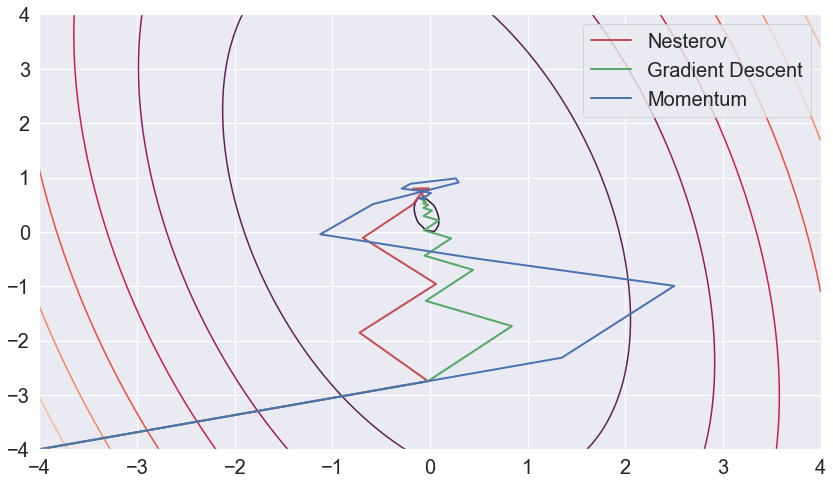

In [41]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(nesterov_x, nesterov_y, 'r', linewidth=2, label='Nesterov')
plt.plot(gradient_x, gradient_y ,'g', linewidth=2, label='Gradient Descent')
plt.plot(momentum_x, momentum_y ,'b', linewidth=2, label='Momentum')

plt.legend(fontsize=20)
plt.contour(x, y, f_x)

In [46]:
print("Nesterov:", len(nesterov['conv_array']))
print("Momentum:", len(momentum['conv_array']))
print("Gradient Descent:", len(gradient['conv_array']))

Nesterov: 42
Momentum: 56
Gradient Descent: 69


Таким образом мы видим, что градиентный спуск работает дольше всех. (В отличие от методов, использующих момент). Также на графикк видно, что шаги, приближающие нас к цели меньше всего так раз у градиентного спуска. 